<a href="https://colab.research.google.com/github/kicysh/final_task_of_world_model_lecture_2021/blob/main/src/LDVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip

In [1]:
!pip install scanpy scikit-misc

     |████████████████████████████████| 2.0 MB 4.3 MB/s 
     |████████████████████████████████| 8.8 MB 30.2 MB/s 
     |████████████████████████████████| 86 kB 7.7 MB/s 
     |████████████████████████████████| 96 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 48.3 MB/s 
     |████████████████████████████████| 63 kB 3.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=2316bc38f6dbaf95e2c1e31573faacb0e829f0a6e771a9687b6f6bd23818a405
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=65dbb9407adf7d16947aba7b3fe41c3c8523121fad4c887ef88ef2d0bb4ee831
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=e8dd6b4cd0077b763a8be44b2d24797b4f96d73d78483

# data

In [2]:
!mkdir data
!gsutil cp gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad /content/data
path_of_data = '/content/data/pijuan_sala_atlas.h5ad'


Copying gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad...
\ [1 files][  1.0 GiB/  1.0 GiB]   20.5 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


# setting


In [3]:
# setting
SETTING_BATCHNORM_EPS = 0.001
SETTING_BATCHNORM_MOMENTUM = 0.01
SETTING_ENCODER_Z_DROPOUT_P = 0.1
SETTING_ENCODER_L_DROPOUT_P = 0.1
SETTING_HIDDEN_DIM = 128
SETTING_EPS = 1e-8

USE_CUDA = True
SETTING_BATCH_SIZE = 256

# model

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import logsumexp
from torch.distributions import Normal, kl_divergence


rng = np.random.RandomState(1234)
random_state = 42


In [5]:
import scanpy as sc
adata = sc.read_h5ad(path_of_data)
adata

AnnData object with n_obs × n_vars = 139331 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name'

In [6]:
idx = adata.obs.query('not doublet').index
#idx = np.random.choice(idx, 20000, replace=False)
adata = adata[idx]
sc.pp.highly_variable_genes(adata,n_top_genes=1000 ,flavor='seurat_v3')
print(adata)
#sc.pp.filter_genes(adata, min_cells=100)


/usr/local/lib/python3.7/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


AnnData object with n_obs × n_vars = 125775 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'


In [7]:
gene_index = adata.var[adata.var['highly_variable']].index

In [8]:
adata_df = adata.to_df()[gene_index]

In [9]:
#from math import ldexp

class LDVAE(nn.Module):
    """
    :param genes_cnt: Number of input genes
    :param latent_dim: Dimensionality of the latent space 
    """
    def __init__(
        self,
        genes_cnt: int, 
        latent_dim: int = 20
    ):
        super(LDVAE,self).__init__()
        self.local_l_mean = None
        self.local_l_std = None
        self.eps = SETTING_EPS

        self.theta = nn.Parameter(torch.randn(genes_cnt))
        self.encoder_z = nn.Sequential(
            nn.Linear(genes_cnt, SETTING_HIDDEN_DIM),
            nn.BatchNorm1d(SETTING_HIDDEN_DIM,
                           eps=SETTING_BATCHNORM_EPS, 
                           momentum=SETTING_BATCHNORM_MOMENTUM),
            nn.ReLU(),
            nn.Dropout(SETTING_ENCODER_Z_DROPOUT_P)
        )
        self.encoder_z_mean = nn.Linear(SETTING_HIDDEN_DIM,latent_dim)
        self.encoder_z_std = nn.Linear(SETTING_HIDDEN_DIM,latent_dim)

        self.encoder_l = nn.Sequential(
            nn.Linear(genes_cnt, SETTING_HIDDEN_DIM),
            nn.BatchNorm1d(SETTING_HIDDEN_DIM,
                           eps=SETTING_BATCHNORM_EPS, 
                           momentum=SETTING_BATCHNORM_MOMENTUM),
            nn.ReLU(),
            nn.Dropout(SETTING_ENCODER_L_DROPOUT_P)
        )
        self.encoder_l_mean = nn.Linear(SETTING_HIDDEN_DIM, 1)
        self.encoder_l_std = nn.Linear(SETTING_HIDDEN_DIM, 1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, genes_cnt),
            nn.BatchNorm1d(genes_cnt,
                           eps=SETTING_BATCHNORM_EPS, 
                           momentum=SETTING_BATCHNORM_MOMENTUM)
        )


    def forward(self,x):
        x_z = self.encoder_z(x)
        z_mean = self.encoder_z_mean(x_z)
        z_std = torch.exp(self.encoder_z_std(x_z)) 
        z = Normal(z_mean, z_std.sqrt()).rsample()

        x_l = self.encoder_l(x)
        l_mean = self.encoder_l_mean(x_l)
        l_std = torch.exp(self.encoder_l_std(x_l))
        library = Normal(l_mean, l_std.sqrt()).rsample()

        y = self.decoder(z)
        y = torch.exp(library)*torch.softmax(y, dim=-1)
        return [z_mean, z_std, z], [l_mean, l_std, library], y


    def set_local_l_mean_and_std(self, data):
        masked_log_sum =np.ma.log(data.sum(axis=1))
        log_counts = masked_log_sum.filled(0)
        self.local_l_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)[0][0]
        self.local_l_std = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)[0][0]
        return self.local_l_mean, self.local_l_std


    def reconst_error(self,x, mu, theta):
        eps = SETTING_EPS
        log_theta_mu_eps = torch.log(theta + mu + eps)

        res = (
            theta * (torch.log(theta + eps) - log_theta_mu_eps)
            + x * (torch.log(mu + eps) - log_theta_mu_eps)
            + torch.lgamma(x + theta)
            - torch.lgamma(theta)
            - torch.lgamma(x + 1)
        )
        return res


    def loss(self,x):
        zs,ls,y = self.forward(x)
        z_mean, z_std, z = zs
        l_mean, l_std, library = ls

        mean, std = torch.zeros_like(z_mean), torch.ones_like(z_std)
        kl_z = kl_divergence(Normal(z_mean,torch.sqrt(z_std)), Normal(mean, std)).sum(dim=1)

        mean, std = self.local_l_mean*torch.ones_like(l_mean), self.local_l_std*torch.ones_like(l_std)
        kl_l = kl_divergence(Normal(l_mean,torch.sqrt(l_std)), Normal(mean, torch.sqrt(std))).sum(dim=1)

        reconst = self.reconst_error(x, mu=y, theta=torch.exp(self.theta)).sum(dim=-1)        
        return reconst, kl_l ,kl_z

In [10]:
model = LDVAE(genes_cnt = len(adata_df.columns),
              latent_dim = 20)
model.set_local_l_mean_and_std(adata_df.values)
model

LDVAE(
  (encoder_z): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_z_mean): Linear(in_features=128, out_features=20, bias=True)
  (encoder_z_std): Linear(in_features=128, out_features=20, bias=True)
  (encoder_l): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_l_mean): Linear(in_features=128, out_features=1, bias=True)
  (encoder_l_std): Linear(in_features=128, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
)

In [11]:
class GenesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 adata, 
                 transform=None, 
                 target_transform=None):
        self.data = adata
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getattr__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        #label = self.img_labels.iloc[idx, 1]
        if self.transform:
            data = self.transform(data)
        #if self.target_transform:
        #    label = self.target_transform(label)
        return data

In [12]:
# dataloder
dataset = GenesDataset(adata_df.values)


n_samples = len(dataset) 
train_size = int(n_samples* 0.8)
val_size = int(n_samples * 0.2)
test_size = n_samples - train_size - val_size 

dataset_train ,dataset_valid, dataset_test = \
        torch.utils.data.random_split(dataset, [train_size, val_size,test_size])

dataloader_all = torch.utils.data.DataLoader(
    dataset,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=False
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True
)

#dataloader_test = torch.utils.data.DataLoader(
#    dataset_test,
#    batch_size=SETTING_BATCH_SIZE,
#    shuffle=True
#)

In [13]:
#from numpy.ma.core import nonzero
# train
model = LDVAE(genes_cnt = len(adata_df.columns),
              latent_dim = 20)
model.set_local_l_mean_and_std(adata_df.values)
model

n_epochs  = 100
optimizer = optim.Adam(model.parameters(), lr=0.002)#  betas=(0.5,0.999))

device = 'cuda'  if USE_CUDA else 'cpu'
model.to(device)
#_x = nonzero

for epoch in range(n_epochs):
    losses = []

    model.train()
    for x in dataloader_train:
        x = x.to(device)
        #_x = x

        model.zero_grad()

        # forawrd and loss
        reconst, kl_l ,kl_z = model.loss(x)
        loss = torch.mean(-reconst+kl_l +kl_z)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())

    losses_val1 = []
    losses_val2 = []
    losses_val3 = []
    model.eval()
    for x in dataloader_valid:

        x = x.to(device)


        reconst, kl_l ,kl_z = model.loss(x)

        losses_val1.append(torch.mean(-reconst).cpu().detach().numpy())
        losses_val2.append(torch.mean(kl_l).cpu().detach().numpy())
        losses_val3.append(torch.mean(kl_z).cpu().detach().numpy())

    print('EPOCH: %d    Train Loss: %lf    Valid rec: %lf    Valid kl_l: %lf    Valid kl_z: %lf' %
            (epoch+1, np.average(losses),np.average(losses_val1),np.average(losses_val2),np.average(losses_val3)))


EPOCH: 1    Train Loss: 1435.334351    Valid rec: 807.915222    Valid kl_l: 2.377467    Valid kl_z: 22.032368
EPOCH: 2    Train Loss: 797.014832    Valid rec: 691.236084    Valid kl_l: 2.513564    Valid kl_z: 22.767244
EPOCH: 3    Train Loss: 688.830994    Valid rec: 625.699585    Valid kl_l: 2.298156    Valid kl_z: 20.116697
EPOCH: 4    Train Loss: 634.385803    Valid rec: 584.173218    Valid kl_l: 2.389330    Valid kl_z: 19.475550
EPOCH: 5    Train Loss: 603.336670    Valid rec: 567.140503    Valid kl_l: 2.155139    Valid kl_z: 19.598164
EPOCH: 6    Train Loss: 585.162415    Valid rec: 545.509033    Valid kl_l: 2.222978    Valid kl_z: 19.462420
EPOCH: 7    Train Loss: 571.003906    Valid rec: 539.775635    Valid kl_l: 2.518640    Valid kl_z: 19.485926
EPOCH: 8    Train Loss: 561.136292    Valid rec: 527.742126    Valid kl_l: 2.229952    Valid kl_z: 18.479834
EPOCH: 9    Train Loss: 554.121582    Valid rec: 517.522827    Valid kl_l: 2.252628    Valid kl_z: 19.032326
EPOCH: 10    Train

In [14]:
# w
import pandas as pd

_w = model.decoder[0].weight
bn = model.decoder[1]
sigma = torch.sqrt(bn.running_var + bn.eps)
gamma = bn.weight
b = gamma / sigma
bI = torch.diag(b)
loadings = torch.matmul(bI, _w)
loadings = loadings.detach().cpu().numpy()

W = pd.DataFrame(loadings, index=gene_index)
W.to_csv('/content/w.csv')


In [15]:
W

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000025902,0.017243,-0.513267,0.301693,-0.491860,-0.253187,0.318124,-0.243917,0.050221,0.086660,0.210727,-0.019267,-0.483359,-0.713718,0.303053,0.346554,-0.074825,-0.945947,0.026585,-0.068179,0.792100
ENSMUSG00000025927,-0.256015,0.088240,0.062344,-0.613444,-0.214376,-0.052278,-0.326430,-1.436273,0.873174,0.371896,0.211406,0.834329,0.241100,-1.100295,0.086330,0.883633,0.223761,-0.226303,-0.061352,-0.954731
ENSMUSG00000026124,0.141344,0.157248,0.009445,0.182777,0.569046,-0.032174,0.054527,-0.865243,0.223707,0.141375,0.064442,-0.305878,-0.227283,0.713640,-0.028026,0.076488,-0.559509,0.167814,-0.174686,1.149319
ENSMUSG00000026043,-0.041061,0.316716,-0.239347,0.250779,0.006830,0.391197,-0.103160,-1.767351,-0.185832,0.719185,-0.264153,0.476401,0.087315,-0.503627,-0.165408,0.198546,-0.046909,0.063377,-0.738684,-0.362662
ENSMUSG00000045954,0.091830,0.463835,-0.106317,0.191666,-0.082535,-0.416809,0.153527,-1.397781,-0.239847,0.229045,0.040169,0.253857,-0.527805,-0.406212,-0.162887,0.286367,0.229964,0.169077,-0.399140,-0.077325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000100417,0.047175,0.391539,-0.026861,-0.146562,-0.295718,0.104113,0.067067,-0.861966,0.169686,0.323885,0.030354,-0.031690,0.279453,0.128663,-0.265318,0.062810,-0.379951,0.211462,0.844436,0.499407
ENSMUSG00000025219,0.037810,-0.207911,0.449830,-0.040457,0.140184,0.411256,0.303859,-1.655195,-0.259019,-0.185766,-0.037629,-0.002231,0.230664,0.464438,0.149475,-0.125135,-1.107660,-0.132687,1.153587,0.814129
ENSMUSG00000025068,-0.065160,0.276051,-0.135523,-0.088519,-0.178974,-0.017297,-0.035923,0.006075,0.063794,0.103925,0.054630,-0.040057,0.354663,-0.029640,0.018465,0.088641,0.064532,-0.054143,0.969802,0.168422


In [19]:
latent_array  = None
model.eval()
for x in dataloader_all:
    x = x.to(device)
    _z,_,_ = model(x)
    z_mean,_,_ = _z
    z_mean = z_mean.cpu().detach().numpy()
    if latent_array is None:
        latent_array = z_mean
    else:
        latent_array = np.concatenate([latent_array, z_mean])
pd.DataFrame(latent_array,index=adata_df.index).to_csv('/content/z.csv')

In [25]:
pd.DataFrame(latent_array,index=adata_df.index)

In [26]:
import matplotlib.pyplot as plt


In [29]:
w_df = pd.read_csv('/content/w.csv', index_col=0)
z_df = pd.read_csv('/content/z.csv', index_col=0)

In [25]:
w_df = w_df.add_prefix('w')
z_df = w_df.add_prefix('z')

In [27]:
%pylab inline
%config InlineBackend.figure_format ='retina'

import time

import anndata
import matplotlib.colors as mcolors
import pandas as pd

import plotnine as p


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [31]:
z_df = z_df.add_prefix('z')
w_df = w_df.add_prefix('w')

In [32]:


def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained



In [33]:


_, variance_explained = Z_covariance(z_df)
idx = np.argsort(variance_explained)[::-1]



In [34]:
Z_df_ordered = pd.DataFrame(z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = z_df.index
W_df_ordered = pd.DataFrame(w_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = w_df.index

In [36]:
adata = anndata.read('/content/data/pijuan_sala_atlas.h5ad')

In [37]:


W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)



In [38]:


text_shift = {
    (0, 'Fst'): (0.2, -0.2),
    (0, 'Pmp22'): (-0.1, -0.3),
    (0, 'Hoxaas3'): (0.0, 0.3),
    (0, 'Acta2'): (0.0, 0.2),
    (0, 'Nnat'): (0.0, 0.5),
    (0, 'Ifitm1'): (0.0, 0.2),
    
    (1, 'Srgn'): (0., -0.2),
    (1, 'Amn'): (-0.7, 0.),
    
    (2, 'Crabp2'): (0.0, 0.4),
    (2, 'Tdgf1'): (0.0, 0.4),
    (2, 'Cer1'): (-0.6, 0.0),
    (2, 'T'): (-1.3, 0.0),
    
    (3, 'Cdx1'): (0.0, 0.4),
    (3, 'Cdx2'): (-1.0, 0.7),
    (3, 'Cited1'): (-1.6, -0.0),
    (3, 'Phlda2'): (-0.7, 0.0),
    (3, 'T'): (0.0, 0.2),
    (3, 'Ifitm1'): (-0.2, 0.0),
#     (3, 'Rspo2'): (-0.3, 0.0),
#     (3, 'Htr2c'): (0.6, 0.1),
#     (3, 'Col1a1'): (0.0, 0.2),
    
#     (4, 'Ttn'): (0.0, -0.4),
#     (4, 'Sntb1'): (0.0, -0.3),
#     (4, 'Colec12'): (-1.1, 0.1),
#     (4, 'Adam12'): (0.1, 0.4),
#     (4, 'Spon1'): (0.0, 0.2),
#     (4, 'Gm3764'): (-0.2, 0.3),
#     (4, 'C130071C03Rik'): (1.5, -0.35),
    
}



['Prl2a1', 'Cer1', 'Prl3d3', 'Samd3', 'Serpinb9g', 'Cxcl13', 'Dcpp3', 'Serpinb9e']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Hoxc10', 'Hoxa9', 'C5ar1', 'Hoxc9', 'Cldn5', 'Treml1', 'Gimap6', 'AC113508.1']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Hoxaas3', 'Cdx4', 'Cdx1', 'Sprr2a3', 'Rax', 'Cdx2', 'Dkk4', 'Hoxb8']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Msx3', 'Tdgf1', 'Mesp1', 'Mesp2', 'Mixl1', 'Lefty2', 'Bhlha9', 'Slpi']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Ms

FileNotFoundError: ignored

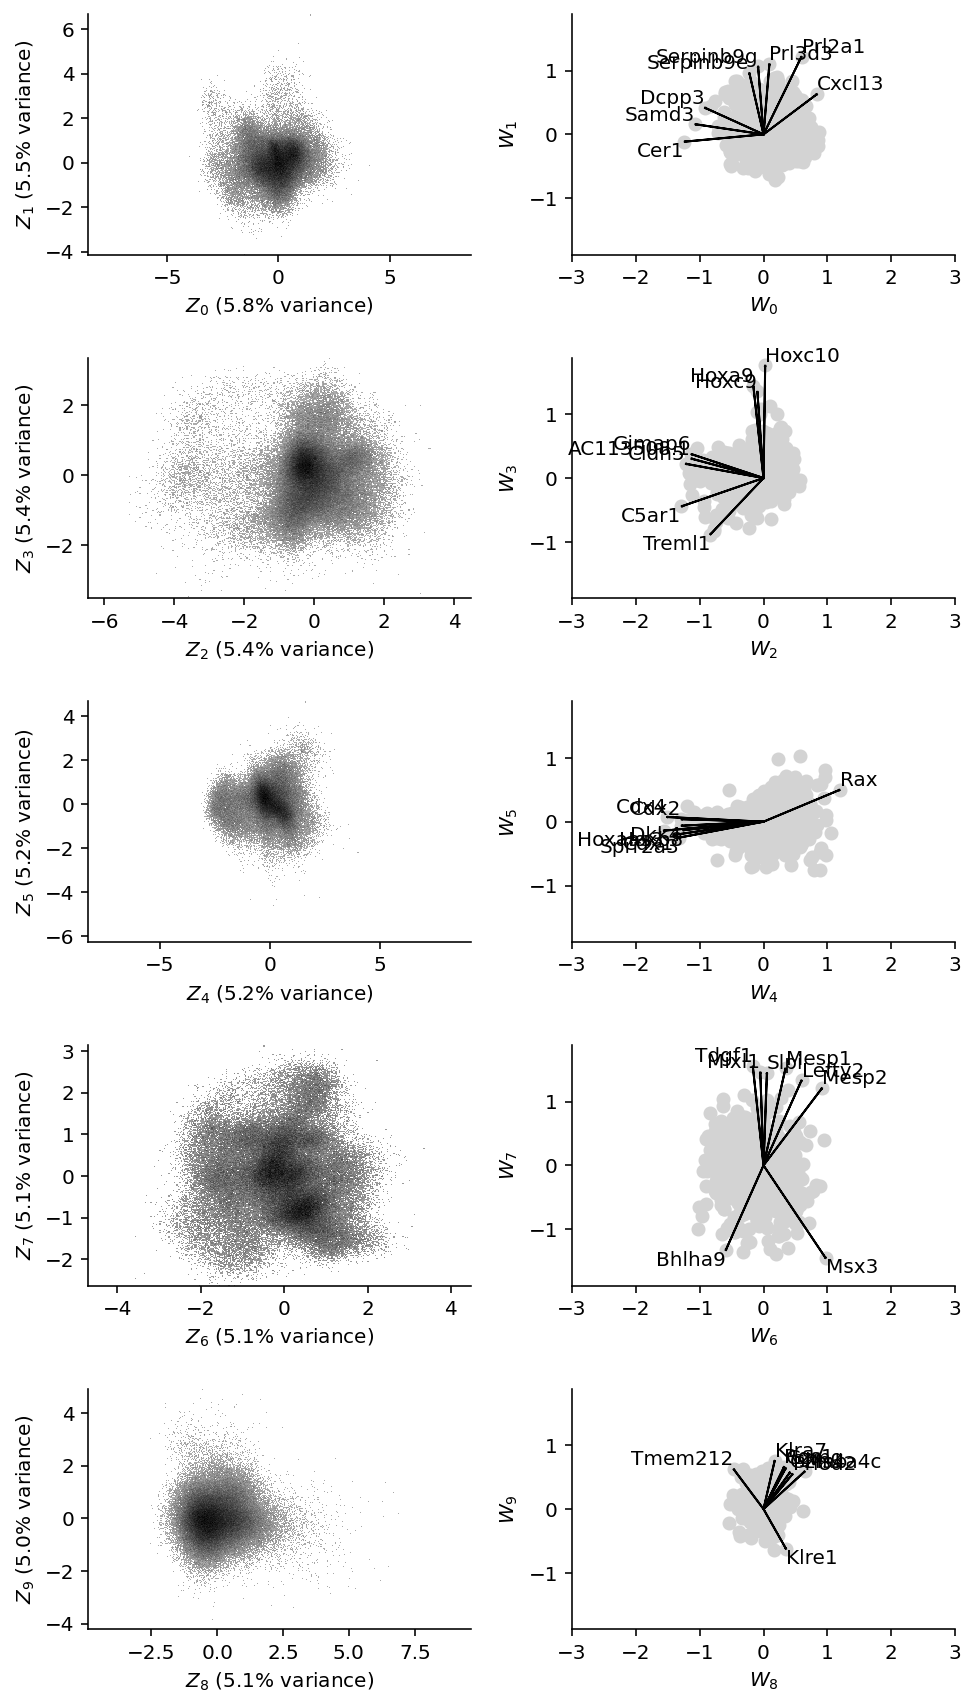

In [39]:
figsize(7, 12)
for i in range(5):
    
    # -- Z plot --
    
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    
    plt.subplot(5, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right'
        if x_ > 0:
            ha = 'left'
            
        va = 'top'
        if y_ > 0:
            va = 'bottom'
            
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True))
        
        xs, ys = 0, 0
        if (i, r.gene_name) in text_shift:
            xs, ys = text_shift[(i, r.gene_name)]
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-3, right=3)
    plt.ylim(bottom=-3, top=3)
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)